## Ceci est un Test pour Trduire ONNX to MIP

In [1]:
import torch
import sys
import csv

sys.path.insert(0, '../ELINA/python_interface/')

from tensorflow_translator import *
from onnx_translator import *
from read_net_file   import *

from analyzer  import *
from optimizer import *

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2023-01-18 09:43:44.858083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-01-18 09:43:44.858140: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2023-01-18 09:43:46.604242: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 09:43:46.606883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/gurobi952/linux64/lib
2023-01-18 09:43:46.606930: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-18 09:43:46.606971: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calcul-02): /proc/driver/nvidia/version does not exist
/home/ramzi.ben-mhenni/eran/tf_verify/optimizer.py:26: UserWarning:

In [2]:
dataset = 'cifar10'

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

if dataset in ['mnist', 'fashion']:
    height, width, channels = 28, 28, 1
else:
    height, width, channels = 32, 32, 3

num_pixels = height * width * channels

In [3]:
is_onnx = False
is_trained_with_pytorch = False
is_gpupoly = False


if is_onnx:
    net_file = "cifar_mlp.onnx"
    model, is_conv = read_onnx_net(net_file)
    translator = ONNXTranslator(model, True)
else:
    net_file ="/home/ramzi.ben-mhenni/eran/data/model/convSmallRELU__Point.pyt"
    net_file ="/home/ramzi.ben-mhenni/eran/data/model/cifar_relu_6_100.tf"
    net_file ="/home/ramzi.ben-mhenni/eran/data/model/cifar_relu_4_100.tf"    
    
    model, is_conv, mean, std = read_tensorflow_net(net_file, num_pixels, is_trained_with_pytorch, is_gpupoly)
    translator = TFTranslator(model, None)


ReLU
	OutShape:  (1, 100)
	WShape:  (3072, 100)
	BShape:  (100,)
ReLU
	OutShape:  (1, 100)
	WShape:  (100, 100)
	BShape:  (100,)
ReLU
	OutShape:  (1, 100)
	WShape:  (100, 100)
	BShape:  (100,)
ReLU
	OutShape:  (1, 100)
	WShape:  (100, 100)
	BShape:  (100,)
ReLU
	OutShape:  (1, 10)
	WShape:  (100, 10)
	BShape:  (10,)
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`


In [4]:
operations, resources = translator.translate()
optimizer = Optimizer(operations, resources)

In [7]:
filename = '../data/'+ dataset+ '_test.csv'
csvfile = open(filename, 'r')
tests = csv.reader(csvfile, delimiter=',')

test = next(tests)
test = next(tests)
test = next(tests)

image = torch.from_numpy(np.float64(test[1:len(test)]) / np.float64(255)).reshape(1, height, width, channels).permute(0, 3, 1, 2).to('cpu')
#image = torch.from_numpy(np.float64(test[1:len(test)]) / np.float64(255))


#input_v = np.array(test_input, dtype=np.float32).reshape([1, 32, 32, 3])
image_v = image.clone().permute(0, 2, 3, 1).flatten().cpu()
#image_v = image.clone().flatten().cpu()

label = np.int(test[0])

# Printing output
print("Image_label : ")
print(label)

Image_label : 
8


/home/ramzi.ben-mhenni/venvpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


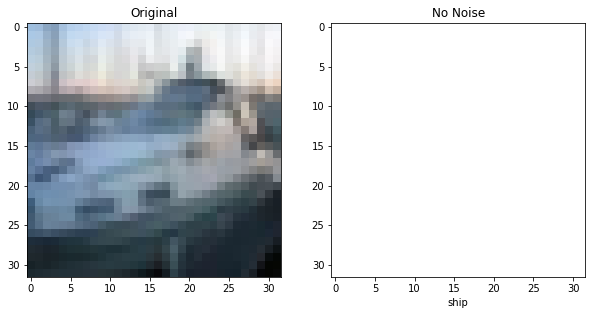

In [8]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img, fig):
    img = img 
    npimg = img.numpy()
    fig.imshow(np.transpose(npimg, (1, 2, 0)))
    
def plot_attack_pred(original, attack):
    # show image and noise
    ax, fig = plt.subplots(nrows=1,ncols=2, figsize=(10,8))
    fig[0].set_title("Attack")
    imshow(torchvision.utils.make_grid(attack), fig[0])
    noise = (original - attack).detach()
    fig[1].set_title("Noise added to original image")
    imshow(10*torchvision.utils.make_grid(noise), fig[1])
    plt.show()

def plot_image_pred(img,name):
    # show image and noise
    ax, fig = plt.subplots(nrows=1,ncols=2, figsize=(10,8))
    fig[0].set_title("Original")
    plt.xlabel(name)
    imshow(torchvision.utils.make_grid(img), fig[0])
    noise = (img - img + 1).detach()
    fig[1].set_title("No Noise")
    imshow(10*torchvision.utils.make_grid(noise), fig[1])
    plt.show()


plot_image_pred(image,class_names[label])

In [9]:
def model_predict(base, input):
    if is_onnx:
        pred = base.run(input)
    else:
        pred = base.run(base.graph.get_operation_by_name(model.op.name).outputs[0], {base.graph.get_operations()[0].name + ':0': input})
    return pred

sess = tf.Session()
#sess = None
# refactor this out of this method
if is_onnx:
    runnable = rt.prepare(model, 'CPU')
elif sess is None:
    config = tf.ConfigProto(device_count={'GPU': 0})
    runnable = tf.Session(config=config)
else:
    runnable = sess



In [10]:
image_vv = np.array(image_v, dtype=np.double)
pred = model_predict(runnable, image_vv)

print(pred)

[[50.50049533  1.64337118  9.46747401  0.          0.          0.
   0.          0.         41.51733587  5.37219362]]


In [ ]:
def normalize(image, means, stds, dataset):
    # normalization taken out of the network
    if len(means) == len(image):
        for i in range(len(image)):
            image[i] -= means[i]
            if stds!=None:
                image[i] /= stds[i]
    elif dataset == 'mnist'  or dataset == 'fashion':
        for i in range(len(image)):
            image[i] = (image[i] - means[0])/stds[0]
    elif(dataset=='cifar10'):
        count = 0
        tmp = np.zeros(3072)
        for i in range(1024):
            tmp[count] = (image[count] - means[0])/stds[0]
            count = count + 1
            tmp[count] = (image[count] - means[1])/stds[1]
            count = count + 1
            tmp[count] = (image[count] - means[2])/stds[2]
            count = count + 1

        
        is_gpupoly = False
        if is_conv and not is_gpupoly:
            for i in range(3072):
                image[i] = tmp[i]
            #for i in range(1024):
            #    image[i*3] = tmp[i]
            #    image[i*3+1] = tmp[i+1024]
            #    image[i*3+2] = tmp[i+2048]
        else:
            count = 0
            for i in range(1024):
                image[i] = tmp[count]
                count = count+1
                image[i+1024] = tmp[count]
                count = count+1
                image[i+2048] = tmp[count]
                count = count+1

                
means = [0.5, 0.5, 0.5]
stds = [1, 1, 1]
normalize(image_v, means, stds, dataset)

In [ ]:
if not is_trained_with_pytorch:
    if dataset == 'mnist' and not config.geometric:
        means = [0]
        stds = [1]
    elif dataset == 'acasxu':

    elif dataset == "cifar10":
        means = [0.4914, 0.4822, 0.4465]
        stds = [0.2023, 0.1994, 0.2010]
    else:
        means = [0.5, 0.5, 0.5]
        stds = [1, 1, 1]




In [ ]:
pred = model_predict(runnable, image_v)
print(pred)

In [ ]:

num_flows =  2* num_pixels
delta = 0.02


specLB = image.clone().permute(0, 2, 3, 1).flatten().cpu() -delta
specUB = image.clone().permute(0, 2, 3, 1).flatten().cpu() +delta

flows_LB = torch.full((num_flows,), -delta).to('cpu')
flows_UB = torch.full((num_flows,), delta).to('cpu')

speLB = torch.cat((specLB, flows_LB))
speUB = torch.cat((specUB, flows_UB))

In [ ]:
#deepzono
# execute_list_deepzono, output_info_deepzono = optimizer.get_deepzono(nn, specLB , specUB )
# use_dict =  optimizer.deepzono_get_dict(execute_list_deepzono)

nn = layers()

#deeppoly
lexpr_weights= None
lexpr_cst=None
lexpr_dim=None
uexpr_weights=None
uexpr_cst=None
uexpr_dim=None
expr_size=0

domain = 'deeppoly'
timeout_lp = 100
timeout_milp = 100
timeout_final_lp=100
timeout_final_milp=100

use_default_heuristic = True
output_constraints = False

testing = False
label= 8
prop = 1
spatial_constraints=None
K=0
s=0

max_milp_neurons=10000
approx_k=False

execute_list_deeppoly, output_info_deeppoly =optimizer.get_deeppoly(nn, specLB, specUB, lexpr_weights, lexpr_cst, lexpr_dim, uexpr_weights, uexpr_cst, uexpr_dim, expr_size, spatial_constraints=None)

output_info_deeppoly

In [ ]:
def get_abstractBigM(nn,ir_list,timeout_lp,timeout_milp):
        """
        processes self.ir_list and returns the resulting abstract element
        """
        man = fppoly_manager_alloc()
        element = ir_list[0].transformer(man)
        nlb = [0]
        nub = [0]
        testing_nlb = []
        testing_nub = []
        
        domain = 'deeppoly'
        
        relu_groups = False
        use_default_heuristic = True
        testing = True
        
        
        for i in range(1, len(ir_list)):
            if type(ir_list[i]) in [DeeppolyReluNode,DeeppolySigmoidNode,DeeppolyTanhNode,DeepzonoRelu,DeepzonoSigmoid,DeepzonoTanh]:
                element_test_bounds = ir_list[i].transformer(nn, man, element, nlb, nub,
                                                                  relu_groups, 'refine' in domain,
                                                                  timeout_lp, timeout_milp,
                                                                  use_default_heuristic, testing,
                                                                  K=1, s=1, use_milp=True,
                                                                  approx=0)
                print("1 :")
                
            else:
                element_test_bounds = ir_list[i].transformer(nn, man, element, nlb, nub,
                                                                  relu_groups, 'refine' in domain,
                                                                  timeout_lp, timeout_milp,
                                                                  use_default_heuristic, testing)
                print("2 :")
                

            if testing and isinstance(element_test_bounds, tuple):
                element, test_lb, test_ub = element_test_bounds
                testing_nlb.append(test_lb)
                testing_nub.append(test_ub)
            else:
                element = element_test_bounds
        if domain in ["refinezono", "refinepoly"]:
            gc.collect()
        if testing:
            return element, testing_nlb, testing_nub
        return element, nlb, nub

In [ ]:
timeout_lp = 100
timeout_milp = 100
element, nlb, nub = get_abstractBigM(nn,execute_list_deeppoly,timeout_lp,timeout_milp)


In [ ]:
print('This network has ' + str(optimizer.get_neuron_count()) + ' neurons.')

for i in range(nn.numlayer):
    print(nn.layertypes[i])
    

In [ ]:

#execute_list = execute_list_deeppoly
#analyzer = Analyzer(execute_list, nn, domain, timeout_lp, timeout_milp, output_constraints,
#                                use_default_heuristic, label, prop, testing, K=K, s=s,
#                                timeout_final_lp=timeout_final_lp, timeout_final_milp=timeout_final_milp,
#                                use_milp=use_milp, complete=complete,
#                                partial_milp=partial_milp, max_milp_neurons=max_milp_neurons)
#terminate_on_failure= True
#dominant_class, nlb, nub, failed_labels, x = analyzer.analyze(terminate_on_failure=terminate_on_failure)

    
#print(failed_labels)
#print(x)
#print(dominant_class)

In [ ]:
#milp_activation_layers = np.nonzero([l in ["ReLU", "Maxpool"] for l in nn.layertypes])[0]
#partial_milp = 0
#### Determine whcich layers, if any to encode with MILP
#if partial_milp < 0:
#    partial_milp = len(milp_activation_layers)
#first_milp_layer = len(nn.layertypes) if partial_milp == 0 else milp_activation_layers[-min(partial_milp, len(milp_activation_layers))]

#first_milp_layer

In [ ]:

relu_groups = None
use_milp=True
complete=True
partial_milp=False
is_nchw=False
partial_milp=2
max_milp_neurons = 1000

counter, var_list, model = create_model(nn, specLB, specUB, nlb, nub, relu_groups, nn.numlayer, use_milp, is_nchw, partial_milp, max_milp_neurons)

num_var = len(var_list)
output_size = num_var - counter
#model.write("model_refinepoly.lp")

In [ ]:
adv_label = 5

obj = LinExpr()
obj += 1 * var_list[counter + label]
obj += -1 * var_list[counter + adv_label]
model.setObjective(obj, GRB.MINIMIZE)

#model.addConstr( var_list[counter + adv_label] >= var_list[counter + label] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 0] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 1] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 2] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 3] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 4] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 5] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 6] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 7] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 8] )
#model.addConstr( var_list[counter + adv_label] >= var_list[counter + 9] )


In [ ]:
#expr_qp= QuadExpr()

#for i in range(num_pixels):
#    expr_qp.add(var_list[i] * var_list[i] - 2*image_v[i] * var_list[i] + image_v[i]*image_v[i]) 

## Set objective
#model.setObjective(expr_qp, GRB.MINIMIZE)

In [ ]:
model.setParam("OutputFlag",1)
model.setParam("TimeLimit", 100)
model.optimize()

In [ ]:
sol_count = f"{model.solcount:d}" if hasattr(model, "solcount") else "None"
obj_bound = f"{model.objbound:.4f}" if hasattr(model, "objbound") else "failed"
obj_val = f"{model.objval:.4f}" if hasattr(model, "objval") else "failed"     

print(f"MILP model status: {model.Status}, Model solution count: {sol_count}, Final solve time: {model.Runtime:.3f}, Final objval : {obj_val} ")
       

In [ ]:
if model.solcount > 0:
    adv_examples = [model.x[0:num_pixels]]
    output_model = [model.x[counter:num_var]]

In [ ]:
print(label)
print(adv_label)
print(output_model)

In [ ]:
adv_examples_img = torch.from_numpy(np.float64(adv_examples)).reshape(1, height, width, channels).permute(0, 3, 1, 2).to('cpu')
plot_attack_pred(image, adv_examples_img)

In [ ]:
image- adv_examples_img